In [1]:
!pip install -U efficientnet

import os, cv2, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from api.get_segmentations import *
from api.get_tabular_dataframe import *
from api.write_tfrecord import *
from api.read_tfrecord import *
from api.get_model import *

import tensorflow as tf

#!pip install tensor-dash
#from tensordash.tensordash import Tensordash

CFG = dict(
    #Execution parameters
    DEVICE = 'GPU',
    AUTOTUNE = None, #let as None
    REPLICAS = None, #let as None
    strategy = None, #let as None

    #Augmentation parameters
    augment = True,
    rot = 170.,
    shr = 2.,
    hzoom = 8.0,
    wzoom = 8.0,
    hshift = 8.0,
    wshift = 8.0,
    
    #Learning_rate parameters
    lr_start = 0.000006,
    lr_max = 0.00000145,
    lr_min = 0.000001,
    lr_rampup = 5,
    lr_sustain = 0,
    lr_decay = 0.85,
    
    #Model parameters
    img_size = 224,
    tabular_size = 19,
    epochs = 100, #high number because we use an early-stopper
    batch_size = 32,
    net_count = 7, #1: effnetB0, X: effnetB0->X-1
    optimizer = 'adam',
    label_smooth_fac = 0.05, #for the loss
)

#Loading CPU, GPU or TPU
if CFG['DEVICE'] == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        CFG['DEVICE'] = "GPU"
if CFG['DEVICE'] != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()
if CFG['DEVICE'] == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
AUTOTUNE = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
CFG['AUTOTUNE'] = AUTOTUNE
CFG['REPLICAS'] = REPLICAS
CFG['strategy'] = strategy

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


# Balancing / Reducing dataset :
1/6 = malignant and 5/6 = benign

In [2]:
# df = pd.read_csv('data/labels.csv')
# #cleaning data
# df.image_name = df.image_name + ".png"
# df['target'] = df['benign_malignant']
# df = df[['image_name', 'target']]
# df.columns = ['filename', 'target']
# #Reducing dataset size: 1/6 = malignant and 5/6 = benign
# malignants = df[df.target=='malignant']
# nbMalignant = len(malignants)
# benign = df[df.target=='benign']
# benign2 = benign.sample(nbMalignant*5, replace=False)
# #concatenating both parts + shuffle
# df = pd.concat([malignants,benign2])
# df = newdf.sample(frac=1).reset_index(drop=True)

# df.to_csv("data/df_clean.csv", index=False)
df = pd.read_csv("data/df_clean.csv")
df.head()

,filename,target
0,ISIC_9515811.png,benign
1,ISIC_2476876.png,benign
2,ISIC_1706912.png,malignant
3,ISIC_7130929.png,malignant
4,ISIC_9115484.png,benign


# Create Segmentations
Possibility to skip this step if we give a segmentation to the input 

In [3]:
# get_segmentations(CFG, df, "data/images/", "data/masks/")

# Create Dataframe with tabular features

In [54]:
# df = get_tabular_dataframe(df, "data/images/", "data/masks/")
# df.to_csv("data/df_tabular.csv", index=False)
df = pd.read_csv("data/df_tabular.csv")
df = df.iloc[:-28] #just to have a multiple of batch_size (TO REMOVE !!)
df.head()

,filename,target,extent,solidity,d/D,4A/(pi*d^2),pi*d/P,4*pi*A/P^2,P/(pi*D),A1,...,B,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,ISIC_9515811.png,benign,0.610266,0.944248,0.472005,0.499472,0.585099,0.788818,0.105987,0.001874,...,0.202568,0.861756,0.938873,0.812158,0.916008,0.931556,0.780384,0.209291,0.663173,0.711402
1,ISIC_2476876.png,benign,0.810011,0.951936,0.602981,0.613236,0.699588,0.842777,0.129099,0.000847,...,0.135155,0.873701,0.910631,0.704706,0.927349,0.896892,0.717130,0.205941,0.674485,0.710345
2,ISIC_1706912.png,malignant,0.684407,0.959819,0.392455,0.424730,0.494768,0.709800,0.100181,0.000530,...,0.259043,0.653675,0.474381,0.368340,0.740163,0.615185,0.616598,0.241312,0.704781,0.649807
3,ISIC_7130929.png,malignant,0.724099,0.896918,0.312285,0.337009,0.416202,0.637939,0.085261,0.000904,...,0.324670,0.811402,0.767166,0.543182,0.869015,0.804770,0.675182,0.225115,0.690675,0.677640
4,ISIC_9115484.png,benign,0.610257,0.816092,0.645730,0.615158,0.617602,0.623507,0.198031,0.001586,...,0.131188,0.796599,0.793255,0.744079,0.852521,0.846222,0.821233,0.235022,0.702246,0.659205


# Create TFRecord

In [55]:
tfrec = write_tfrecord(CFG, df, "data/images/")


Writing TFRecord 0 of 1...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 
----DONE


# Read TFRecord

In [56]:
tfrec = "data/tfrecord-full.tfrec"
dataset = read_tfrecord(CFG, tfrec)

# Create Model

In [7]:
m = get_model(CFG, fine_tune=False, model_weights="model_effnetB0-6_noisy-student_transfer-learning.h5")
m.summary()

165232640/165226952 [==============================] - 24s 0us/step
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
efficientnet-b0 (Functional)    (None, 7, 7, 1280)   4049564     lambda[0][0]                     
__________________________________________________________________________________________________
efficientnet-b1 (Functional)    (None, 7, 7, 1280)   6575232     lambda[0][0]                     
___________________

In [15]:
# callbacks = [tf.keras.callbacks.ReduceLROnPlateau(),
#              getLearnRateCallback(CFG),
#              tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
#              #tf.keras.callbacks.ModelCheckpoint("model_"+str(i)+".h5", save_best_only=True, monitor='val_auc', mode='max', save_weights_only=True)]
# m.fit(
#     dataset,
#     steps_per_epoch=len(df)//CFG['batch_size'],
#     epochs=CFG['epochs'],
#     callbacks=callbacks,
# )

In [57]:
p = m.predict(
    dataset,
    steps = len(df)//CFG['batch_size']
)

In [58]:
ytrue = np.array(df['target']=="malignant").astype('int64')
ypred = np.argmax(p, axis=1)

accuracy: 0.7654702970297029
precision: 0.8317274604267034
recall: 0.8998510796723753
F1score: 0.8644492131616596


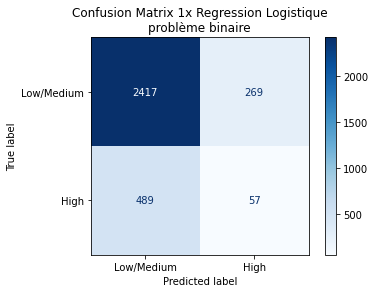

In [60]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Nos predictions en colonne
cm = confusion_matrix(ytrue, ypred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Low/Medium", "High"])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix 1x Regression Logistique\nproblème binaire")

accuracy = np.mean(ytrue==ypred)
precision = cm[0,0]/cm.sum(axis=0)[0]
recall = cm[0,0]/cm.sum(axis=1)[0]
F1score = 2*(recall*precision)/(recall+precision)
print("accuracy:",accuracy)
print("precision:",precision)
print("recall:",recall)
print("F1score:",F1score)

In [ ]:
fig, ax = plt.subplots()
metrics.plot_roc_curve(clf0, X_test, y_test, ax=ax)
ax.set_title('Courbes ROC pour chaque modèle')
plt.show()